In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Input, MultiHeadAttention, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
from training.lib.layers import ForexPrep, FloatEmbedding, PositionalEncoding

import os


In [2]:
DATA_PATH = os.path.abspath("training/Data/daily_csv.csv")
COUNTRY = "United Kingdom"
AVERAGING_GAP = 7
SEQ_LEN = 64 + AVERAGING_GAP
BATCH_SIZE = 32
EPOCHS = 15
HEADS = 4
EMBEDDING_UNITS = 32
FEED_FORWARD_DENSE_LAYERS = [20]
SPLIT_RATIO = 0.33


In [3]:
def load_data(path=DATA_PATH, country=COUNTRY) -> np.ndarray:
	df = pd.read_csv(path)
	df = df.dropna()
	df = df[df["Country"] == country]
	return df["Value"].to_numpy()


In [ ]:
def create_model(seq_len=SEQ_LEN, heads=HEADS, averaging_gap=AVERAGING_GAP, embedding_units=EMBEDDING_UNITS, ff_dense_layers=FEED_FORWARD_DENSE_LAYERS) -> Model:
	input0 = Input(shape=(seq_len, 1))
	prep = ForexPrep(average_gap=averaging_gap)(input0)
	embedding = FloatEmbedding(embedding_units)(prep)
	positional_encoding = PositionalEncoding()(embedding)
	multi_head = MultiHeadAttention(heads, positional_encoding.shape[1])(positional_encoding, positional_encoding)
	ff_dense = Dense(ff_dense_layers[0], activation="relu")(multi_head)
	for units in ff_dense_layers[1:]:
		ff_dense = Dense(units, activation="relu")(ff_dense)
	shrink_dense = Dense(1, activation="relu")(ff_dense)
	reshaped = tf.reshape(shrink_dense, (-1, shrink_dense.shape[1]))
	ff_dense = Dense(ff_dense_layers[0], activation="relu")(reshaped)
	for units in ff_dense_layers[1:]:
		ff_dense = Dense(units, activation="relu")(ff_dense)
	output = tf.reshape(Dense(1, activation="relu")(ff_dense), (-1,))
	
	return Model(inputs=input0, outputs=output)


In [5]:
def prepare_data(data: np.ndarray, seq_len=SEQ_LEN):
	if len(data.shape) == 2:
		data = data.reshape((-1,))
	
	data_len = data.shape[0] - seq_len
	
	X = np.zeros((data_len, seq_len))
	y = np.zeros((data_len,))
	
	for i in range(data_len):
		X[i] = data[i:i+seq_len]
		y[i] = data[i+seq_len]
	
	return X, y


In [ ]:
data = load_data()
X, y = prepare_data(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_RATIO, random_state=42)


In [8]:
model = create_model()
model.compile(optimizer="adam", loss="mse")

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 135, 1)]     0                                            
__________________________________________________________________________________________________
forex_prep (ForexPrep)          (None, 128, 2)       0           input_1[0][0]                    
__________________________________________________________________________________________________
float_embedding (FloatEmbedding (None, 128, 64)      192         forex_prep[0][0]                 
__________________________________________________________________________________________________
positional_encoding (Positional (None, 128, 64)      0           float_embedding[0][0]            
______________________________________________________________________________________________

In [10]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/15


  1/122 [..............................] - ETA: 5:24 - loss: 0.2880

  2/122 [..............................] - ETA: 54s - loss: 1.8482 

  3/122 [..............................] - ETA: 52s - loss: 1.9921

  4/122 [..............................] - ETA: 53s - loss: 1.9474

  5/122 [>.............................] - ETA: 51s - loss: 1.8654

  6/122 [>.............................] - ETA: 51s - loss: 1.7708

  7/122 [>.............................] - ETA: 51s - loss: 1.6775

  8/122 [>.............................] - ETA: 50s - loss: 1.5988

  9/122 [=>............................] - ETA: 50s - loss: 1.5353

 10/122 [=>............................] - ETA: 49s - loss: 1.4799

 11/122 [=>............................] - ETA: 48s - loss: 1.4279

 12/122 [=>............................] - ETA: 47s - loss: 1.3783

 13/122 [==>...........................] - ETA: 47s - loss: 1.3318

 14/122 [==>...........................] - ETA: 46s - loss: 1.2891

 15/122 [==>...........................] - ETA: 45s - loss: 1.2503

 16/122 [==>...........................] - ETA: 45s - loss: 1.2151

 17/122 [===>..........................] - ETA: 44s - loss: 1.1828

 18/122 [===>..........................] - ETA: 43s - loss: 1.1530

KeyboardInterrupt: 

In [74]:
model.evaluate(X_test, y_test)

  1/121 [..............................] - ETA: 27s - loss: 3.4618e-05

  4/121 [..............................] - ETA: 2s - loss: 3.6681e-05 

  7/121 [>.............................] - ETA: 2s - loss: 4.4864e-05

 10/121 [=>............................] - ETA: 2s - loss: 5.3598e-05

 13/121 [==>...........................] - ETA: 2s - loss: 6.9825e-05

 17/121 [===>..........................] - ETA: 1s - loss: 6.9504e-05

 21/121 [====>.........................] - ETA: 1s - loss: 6.8428e-05

 25/121 [=====>........................] - ETA: 1s - loss: 6.5358e-05

 29/121 [======>.......................] - ETA: 1s - loss: 6.4486e-05

 33/121 [=======>......................] - ETA: 1s - loss: 6.3112e-05

 36/121 [=======>......................] - ETA: 1s - loss: 6.6328e-05

 40/121 [========>.....................] - ETA: 1s - loss: 6.8002e-05

 44/121 [=========>....................] - ETA: 1s - loss: 6.7153e-05

 48/121 [==========>...................] - ETA: 1s - loss: 6.4955e-05

 51/121 [===========>..................] - ETA: 1s - loss: 1.4542e-04

 55/121 [============>.................] - ETA: 1s - loss: 1.7268e-04

 59/121 [=============>................] - ETA: 1s - loss: 1.6566e-04

 63/121 [==============>...............] - ETA: 0s - loss: 1.6159e-04

 66/121 [===============>..............] - ETA: 0s - loss: 1.5748e-04

 69/121 [================>.............] - ETA: 0s - loss: 1.5291e-04

 72/121 [================>.............] - ETA: 0s - loss: 1.4927e-04

 76/121 [=================>............] - ETA: 0s - loss: 1.4457e-04

 80/121 [==================>...........] - ETA: 0s - loss: 1.3966e-04

 84/121 [===================>..........] - ETA: 0s - loss: 1.3524e-04

 88/121 [====================>.........] - ETA: 0s - loss: 1.3162e-04

 92/121 [=====================>........] - ETA: 0s - loss: 1.2954e-04

 96/121 [======================>.......] - ETA: 0s - loss: 1.2771e-04

 99/121 [=======================>......] - ETA: 0s - loss: 1.2486e-04

103/121 [========================>.....] - ETA: 0s - loss: 1.2224e-04

106/121 [=========================>....] - ETA: 0s - loss: 1.2070e-04

110/121 [==========================>...] - ETA: 0s - loss: 1.3441e-04

114/121 [===========================>..] - ETA: 0s - loss: 1.4998e-04

118/121 [============================>.] - ETA: 0s - loss: 1.4680e-04

121/121 [==============================] - 2s 16ms/step - loss: 1.4437e-04


0.00014437444042414427

In [81]:
X_predict = model.predict(X_train)

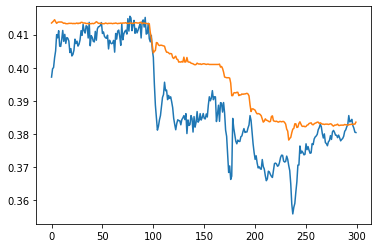

In [90]:
plt.plot(X_predict[:300])
plt.plot(y_train[:300])